In [558]:
import numpy as np
import scipy.signal
from scipy.io import wavfile
import scipy.io.wavfile
import librosa
import matplotlib.pyplot as plt

from pandas import DataFrame

from scipy.signal.windows import hamming
from scipy.fft import fft

In [559]:
def initialize():
    path_hl = "NguyenAmHuanLuyen-16k"
    path_kt = "NguyenAmKiemThu-16k"
    folders_hl = [
        "01MDA", "02FVA", "03MAB", "04MHB", "05MVB", "06FTB", "07FTC",
        "08MLD", "09MPD", "10MSD", "11MVD", "12FTD", "14FHH", "15MMH",
        "16FTH", "17MTH", "18MNK", "19MXK", "20MVK", "21MTL", "22MHL"
    ]
    folders_kt = [
        "23MTL", "24FTL", "25MLM", "27MCM", "28MVN", "29MHN", "30FTN",
        "32MTP", "33MHP", "34MQP", "35MMQ", "36MAQ", "37MDS", "38MDS",
        "39MTS", "40MHS", "41MVS", "42FQT", "43MNT", "44MTT", "45MDV"
    ]
    files = ["a.wav", "e.wav", "i.wav", "o.wav", "u.wav"]
    f_d = 0.03   # Duration of one frame (30 ms)
    f_s = 0.01   # Step size for frame shift (10 ms)
    N_FFTs = [512, 1024, 2048]
    N_MFCCs = [13, 26, 39]
    Ks = [1, 2, 3, 4, 5]
    return path_hl, path_kt, folders_hl, folders_kt, files, f_d, f_s, N_FFTs, N_MFCCs, Ks
# Example of how to use the function
path_hl, path_kt, folders_hl, folders_kt, files, f_d, f_s, N_FFTs, N_MFCCs, Ks = initialize()
# print
print(path_hl)
print(path_kt)
print(folders_hl)
print(folders_kt)
print(files)
print(f_d)
print(f_s)
print(N_FFTs)
print(N_MFCCs)
print(Ks)



NguyenAmHuanLuyen-16k
NguyenAmKiemThu-16k
['01MDA', '02FVA', '03MAB', '04MHB', '05MVB', '06FTB', '07FTC', '08MLD', '09MPD', '10MSD', '11MVD', '12FTD', '14FHH', '15MMH', '16FTH', '17MTH', '18MNK', '19MXK', '20MVK', '21MTL', '22MHL']
['23MTL', '24FTL', '25MLM', '27MCM', '28MVN', '29MHN', '30FTN', '32MTP', '33MHP', '34MQP', '35MMQ', '36MAQ', '37MDS', '38MDS', '39MTS', '40MHS', '41MVS', '42FQT', '43MNT', '44MTT', '45MDV']
['a.wav', 'e.wav', 'i.wav', 'o.wav', 'u.wav']
0.03
0.01
[512, 1024, 2048]
[13, 26, 39]
[1, 2, 3, 4, 5]


In [560]:
def calPerConMatrix(confusion_matrix):
    total_sum = 0
    num_samples = 21
    for i in range(5):
        # Calculate the accuracy percentage for each vowel
        percent = float(confusion_matrix[i + 1][i + 1]) / num_samples * 100
        confusion_matrix[i + 1][6] = percent
        total_sum += percent
    confusion_matrix[6][6] = total_sum / 5
    print(confusion_matrix)
    return confusion_matrix
# Example usage
# Initialize a confusion matrix with random values for demonstration
# In practice, replace this with the actual confusion matrix data
# cm_size = 6  # 5 classes + 1 column/row for percentages
# confusion_matrix_np = np.random.randint(0, 21, size=(cm_size, cm_size))
# # Calculate percentages
# confusion_matrix_np = calPerConMatrix(confusion_matrix_np)
# print(confusion_matrix_np)


In [561]:
def euclidean(v1, v2):

    # distance = np.sqrt(np.sum((v1 - v2) ** 2))

    distance = np.linalg.norm(v1 - v2)

    return distance

In [562]:
def process_signal(path, folder, file, f_d, f_s):
    # Construct the full path for the WAV file
    filepath = f"{path}/{folder}/{file}"

    # Read WAV file
    Fs, data = wavfile.read(filepath)
    T = 1 / Fs                          # Period
    n = len(data)                       # Number of samples in the signal
    t = n * T                           # Signal duration
    data = data / abs(max(data))        # Normalize amplitude to [-1, 1]
    # Number of samples in one frame (25ms)
    frame_len = round(f_d * Fs)
    # Number of samples to shift the frame (15ms)
    frame_shift_len = round(f_s * Fs)
    # Total number of frames
    n_f = int(np.floor((t - f_d) / f_s))
    # Split the data into frames
    frames = []
    index = 0
    for i in range(n_f):
        frame = data[index: index + frame_len]
        frames.append(frame)
        index += frame_shift_len
    frames = np.array(frames)
    # Calculate Short-Time Energy (STE) for each frame
    ste = np.sum(frames ** 2, axis=1)
    # Normalize STE to the range [0, 1]
    ste /= max(ste)
    # IDs containing speech frames
    id = np.where(ste >= 0.1)[0]
    len_id = len(id)
    distance = int(np.ceil((id[-1] - id[0]) / 3))
    frame_start = id[0] + distance
    frame_end = id[0] + 2 * distance
    t1 = np.arange(0, t, T)
    t2 = np.arange(0, (n_f - 1) * f_s, f_s)
    # Uncomment to enable plotting
    # plt.figure()
    # plt.plot(t1, data)
    # plt.plot(t2, ste, '.', linewidth=1.5)
    # plt.axvline(x=(id[0] - 1) * f_s, color='r', linewidth=1.5)
    # plt.axvline(x=(frame_start - 1) * f_s, color='b', linewidth=1.5)
    # plt.axvline(x=(frame_end - 1) * f_s, color='b', linewidth=1.5)
    # plt.axvline(x=(id[-1] - 1) * f_s, color='r', linewidth=1.5)
    # plt.legend(['Signal', 'STE', 'Bounds', 'Stable bounds'])
    # plt.title(f"{folder}-{file}")
    
    return frames, frame_start, frame_end
# Example usage
# frames, frame_start, frame_end = process_signal("NguyenAmHuanLuyen-16k", "01MDA", "a.wav", 0.03, 0.01)


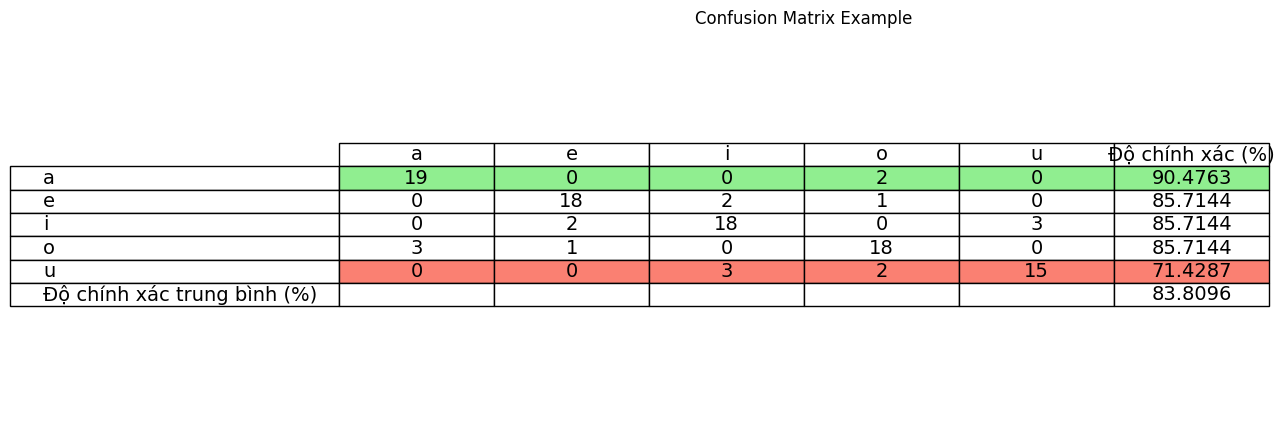

In [563]:
# import matplotlib.pyplot as plt
# from pandas import DataFrame
# import numpy as np
# def draw_confusion_matrix(confusion_matrix, title1):
#     # Convert confusion_matrix to a DataFrame for better handling of rows and column names
#     df_cm = DataFrame(
#         [row[1:] for row in confusion_matrix[1:-1]],  # Exclude the header row and the last row for the data
#         columns=confusion_matrix[0][1:],  # Exclude the first column of the header row for the column names
#         index=[row[0] for row in confusion_matrix[1:-1]]  # Use the first element of each row for the row names
#     )
#     # Append the average row separately to handle its unique structure
#     df_cm.loc[confusion_matrix[-1][0]] = np.nan
#     df_cm.iloc[-1, -1] = confusion_matrix[-1][-1]   # Set the last cell with the average accuracy value
#     # Extract the accuracy percentages for all the classes except the average
#     accuracies = df_cm.iloc[:-1, -1].astype(float)
#     # Find the indexes for the maximum and minimum accuracy values
#     max_index = accuracies.idxmax()
#     min_index = accuracies.idxmin()
#     # Convert the DataFrame back to a numpy array for display
#     data = df_cm.to_numpy()
#     # Plot the table using matplotlib
#     fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the figure size as needed
#     ax.set_title(title1)
#     ax.axis('off')  # Hide the axes
#     # Create the table and apply the styles
#     table = ax.table(
#         cellText=data,
#         rowLabels=df_cm.index,
#         colLabels=df_cm.columns,
#         loc='center',
#         cellLoc='center'
#     )
#     table.auto_set_font_size(False)
#     table.set_fontsize(16)
#     table.scale(1, 1.5)  # Adjust table scale for better fit
#     # Highlight the rows with the maximum and minimum accuracies
#     for i, label in enumerate(df_cm.index):
#         if label == max_index:
#             for j in range(len(df_cm.columns)):
#                 table[(i + 1, j)].set_facecolor("lightgreen")
#         elif label == min_index:
#             for j in range(len(df_cm.columns)):
#                 table[(i + 1, j)].set_facecolor("salmon")
#     plt.show()
# # Example usage
# confusion_matrix = [
#     ['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'],
#     ['a', 19, 0, 0, 2, 0, 90.476],
#     ['e', 0, 18, 2, 1, 0, 85.714],
#     ['i', 0, 0, 18, 0, 3, 85.714],
#     ['o', 2, 1, 0, 18, 0, 85.714],
#     ['u', 0, 0, 6, 0, 15, 71.428],
#     ['Độ chính xác trung bình (%)', '', '', '', '', '', 83.809]
# ]
# draw_confusion_matrix(confusion_matrix, "Confusion Matrix Example")


# def draw_confusion_matrix(confusion_matrix, title1):
#     # Convert confusion_matrix to a DataFrame for better handling of rows and column names
#     df_cm = DataFrame(
#         confusion_matrix[1:],  # Exclude the header row for the data
#         columns=confusion_matrix[0],  # Use the header row for the column names
#         index=[row[0] for row in confusion_matrix[1:]]  # Use the first column for the row names
#     )
#     # Extract the accuracy percentages for all the classes except the average
#     accuracies = df_cm.iloc[:-1, -1].astype(float)
#     # Find the indexes for the maximum and minimum accuracy values
#     max_index = accuracies.idxmax()
#     min_index = accuracies.idxmin()
#     # Convert the DataFrame back to a numpy array for display
#     data = df_cm.to_numpy()
#     # Plot the table using matplotlib
#     fig, ax = plt.subplots(figsize=(12, 2))  # Adjust the figure size as needed
#     ax.set_title(title1)
#     ax.axis('off')  # Hide the axes
#     # Create the table and apply the styles
#     table = ax.table(
#         cellText=data,
#         rowLabels=df_cm.index,
#         colLabels=df_cm.columns,
#         loc='center',
#         cellLoc='center'
#     )
#     table.auto_set_font_size(False)
#     table.set_fontsize(16)
#     table.scale(1, 1.5)  # Adjust table scale for better fit
#     # Highlight the rows with the maximum and minimum accuracies
#     for (i, row) in enumerate(confusion_matrix[1:], start=1):
#         if row[0] == max_index:
#             for j, _ in enumerate(row[1:], start=1):
#                 table[(i, j)].set_facecolor("lightgreen")
#         elif row[0] == min_index:
#             for j, _ in enumerate(row[1:], start=1):
#                 table[(i, j)].set_facecolor("salmon")
#     plt.show()
# # Example usage
# confusion_matrix = [
#     ['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'],
#     ['a', 19, 0, 0, 2, 0, 90.476],
#     ['e', 0, 18, 2, 1, 0, 85.714],
#     ['i', 0, 0, 18, 0, 3, 85.714],
#     ['o', 2, 1, 0, 18, 0, 85.714],
#     ['u', 0, 0, 6, 0, 15, 71.428],
#     ['Độ chính xác trung bình (%)', '', '', '', '', '', 83.809]
# ]
# draw_confusion_matrix(confusion_matrix, "Confusion Matrix Example")



def draw_confusion_matrix(confusion_matrix, title1):
    # Format the last column of the confusion matrix (percentages) to have 4 decimal places and keep NaNs as they are
    for row in confusion_matrix[1:]:
        if type(row[-1]) == float:  # Check if the value is a float before formatting to avoid formatting strings
            row[-1] = "{:.4f}".format(row[-1])
        else:
            row[-1] = ""  # If NaN or any non-float value, replace with empty string
    # Convert confusion_matrix to DataFrame for better handling of rows and column names
    df_cm = DataFrame(
        [row[1:] for row in confusion_matrix[1:]],  # Exclude the first column (labels)
        columns=confusion_matrix[0][1:],  # Use the first row for column names, excluding the first entry
        index=[row[0] for row in confusion_matrix[1:]]  # Use the first column for index labels
    )
    # Plotting using matplotlib
    fig, ax = plt.subplots(figsize=(12, 5))  # Adjust for an appropriate figure size
    ax.set_title(title1)
    ax.axis('off')  # Hide axes
    tab = ax.table(cellText=df_cm.values, cellLoc='center', loc='center', rowLabels=df_cm.index, colLabels=df_cm.columns)
    tab.auto_set_font_size(False)
    tab.set_fontsize(14)
    tab.scale(1, 1.4)

    # Apply color formatting for maximum and minimum values
    max_index = df_cm.iloc[:-1, -1].astype(float).idxmax()  # Get the max percentage excluding the average
    min_index = df_cm.iloc[:-1, -1].astype(float).idxmin()  # Get the min percentage excluding the average

    for (i, row) in enumerate(df_cm.iterrows(), start=1):
        if row[0] == max_index :  # Highlight max accuracy row
            for j in range(len(df_cm.columns)):
                tab[(i, j)].set_facecolor('lightgreen')
        if row[0] == min_index:  # Highlight min accuracy row
            for j in range(len(df_cm.columns)):
                tab[(i, j)].set_facecolor('salmon')
    plt.show()
# Example usage with formatted percentages and NaN values
confusion_matrix = [
    ['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'],
    ['a', 19, 0, 0, 2, 0, 90.476255],
    ['e', 0, 18, 2, 1, 0, 85.714355],
    ['i', 0, 2, 18, 0, 3, 85.714355],
    ['o', 3, 1, 0, 18, 0, 85.714355],
    ['u', 0, 0, 3, 2, 15, 71.428655],
    ['Độ chính xác trung bình (%)', "", "", "", "", "", 83.809555]
]
draw_confusion_matrix(confusion_matrix, "Confusion Matrix Example")


In [564]:
def characteristic_vector_fft(frames, frame_start, frame_end, N_FFT):
    # Assume frames is a NumPy 2D array with shape (number_of_frames, samples_per_frame)
    w = hamming(frames.shape[1])
    frame_v = w * frames[frame_start-1]  # -1 to convert from 1-based to 0-based indexing
    X = np.abs(fft(frame_v, N_FFT))
    # Accumulate the FFT spectra across the specified range of frames
    for k in range(frame_start, frame_end):
        frame1 = frames[k]
        frame_v = w * frame1
        # Extract the FFT vector of a single signal frame
        X = X + np.abs(fft(frame_v, N_FFT))
    # Calculate the characteristic vector for a vowel of a speaker
    vector = X / (frame_end - frame_start + 1)
    return vector
# Example usage:
# Provide the frames, frame_start, frame_end and N_FFT parameters as needed.
# The frames can be loaded or processed from audio using other Python functions.
# The result will be a characteristic vector from the given frames.


In [565]:
def draw_character_vector_fft(files, vectors, n_fft, title1):
    Fs = 16000
    freq = np.linspace(0, Fs/2, int(n_fft/2))
    plt.figure(figsize=(10, 5))
    plt.plot(freq, vectors[0, :int(n_fft/2)], 'r', label=files[0])
    plt.plot(freq, vectors[1, :int(n_fft/2)], 'g', label=files[1])
    plt.plot(freq, vectors[2, :int(n_fft/2)], 'b', label=files[2])
    plt.plot(freq, vectors[3, :int(n_fft/2)], 'y', label=files[3])
    plt.plot(freq, vectors[4, :int(n_fft/2)], 'k', label=files[4])
    plt.title('Các vector đặc trưng của nguyên âm')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('FFT Magnitude')
    plt.legend()
    plt.show()
# Example usage
# files = ["file1.wav", "file2.wav", "file3.wav", "file4.wav", "file5.wav"]
# vectors = np.random.rand(5, 8000)  # Replace with actual vectors
# n_fft = 16000
# title1 = "Character Vectors FFT"
# draw_character_vector_fft(files, vectors, n_fft, title1)


In [566]:
def training_fft(path_hl, folders_hl, files, f_d, f_s, N_FFT):
    vectors = np.zeros((5, N_FFT))  # Assuming vectors is a 2D array of 5 rows and N_FFT columns
    # Loop through each vowel to calculate its characteristic vector
    for i in range(5):  # Python is zero-indexed while MATLAB is 1-indexed
        X = None
        for j in range(21):
            # Mark the region with stable spectral features characteristic of the vowel
            frames, frame_start, frame_end = process_signal(path_hl, folders_hl[j], files[i], f_d, f_s)
            # Calculate the characteristic vector of a vowel from 21 speakers
            if j == 0:  # Use zero-based indexing
                X = characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
            else:
                X += characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
        # Calculate the average characteristic vector for a vowel from 21 speakers
        vectors[i, :] = X / 21
    return vectors
# Example usage (given the necessary functions were properly implemented in Python):
# path_hl = "path/to/high/level/folder"
# folders_hl = ["folder1", "folder2", "folder3", "folder4", "folder5"]
# files = ["file1", "file2", "file3", "file4", "file5"]
# f_d = 0.025
# f_s = 0.01
# N_FFT = 256
# vectors = training_fft(path_hl, folders_hl, files, f_d, f_s, N_FFT)


In [567]:
def testFFT(path_kt, folders_kt, files, f_d, f_s, N_FFT, vectors):
    confusion_matrix = [
        ["", "a", "e", "i", "o", "u", "Độ chính xác (%)"],
        ["a", 0, 0, 0, 0, 0, 0],
        ["e", 0, 0, 0, 0, 0, 0],
        ["i", 0, 0, 0, 0, 0, 0],
        ["o", 0, 0, 0, 0, 0, 0],
        ["u", 0, 0, 0, 0, 0, 0],
        ["Độ chính xác trung bình (%)", "", "", "", "", "", 0]
    ]

    for i in range(5):  # MATLAB is 1-indexed, Python is 0-indexed
        for j in range(21):
            # You would need to define processSignal and characteristicVectorFFT in Python
            frames, frame_start, frame_end = process_signal(path_kt, folders_kt[j], files[i], f_d, f_s)
            vector = characteristic_vector_fft(frames, frame_start, frame_end, N_FFT)
            # You would need to define euclidean in Python or use np.linalg.norm for Euclidean distance
            min_dist = euclidean(vectors[0, :], vector)
            id = 0  # Changed to 0 since Python arrays are 0-indexed
            for k in range(1, 5):
                min_t = euclidean(vectors[k, :], vector)
                if min_t < min_dist:
                    min_dist = min_t
                    id = k
            # Update the numeric part of the confusion matrix
            confusion_matrix[i + 1][id + 1] += 1
    # Update the accuracy percentage on the confusion matrix if needed
    # ...
    print(confusion_matrix)
    return confusion_matrix
# Definitions for the undefined functions in this code should be added or modified accordingly.
# Example usage:
# confusion_matrix = testFFT(path_kt, folders_kt, files, f_d, f_s, N_FFT, vectors)


In [568]:
def Bai2(path_hl, path_kt, folders_hl, folders_kt, files, N_FFTs, f_d, f_s):
    for N_FFT in N_FFTs:
        vectors = training_fft(path_hl, folders_hl, files, f_d, f_s, N_FFT)
        title = f"Vector đặc trưng FFT với N_FFT = {N_FFT}"
        draw_character_vector_fft(files, vectors, N_FFT, title)
        # Perform testing and obtain confusion matrix
        confusion_matrix = testFFT(path_kt, folders_kt, files, f_d, f_s, N_FFT, vectors)
        # Calculate the percentage of correct and incorrect recognitions
        confusion_matrix = calPerConMatrix(confusion_matrix)
        # Draw the confusion matrix
        title = f"Confusion matrix with N_FFT = {N_FFT}"
        draw_confusion_matrix(confusion_matrix, title)


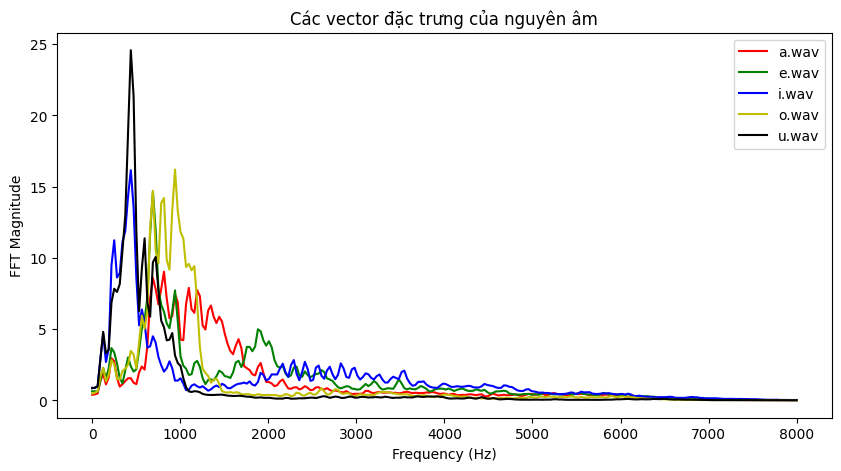

C:\Users\tienn\AppData\Local\Temp\ipykernel_17400\2383558284.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read(filepath)


[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 19, 0, 0, 2, 0, 0], ['e', 0, 18, 2, 1, 0, 0], ['i', 0, 0, 18, 0, 3, 0], ['o', 2, 1, 0, 18, 0, 0], ['u', 0, 0, 6, 0, 15, 0], ['Độ chính xác trung bình (%)', '', '', '', '', '', 0]]
[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 19, 0, 0, 2, 0, 90.47619047619048], ['e', 0, 18, 2, 1, 0, 85.71428571428571], ['i', 0, 0, 18, 0, 3, 85.71428571428571], ['o', 2, 1, 0, 18, 0, 85.71428571428571], ['u', 0, 0, 6, 0, 15, 71.42857142857143], ['Độ chính xác trung bình (%)', '', '', '', '', '', 83.80952380952382]]


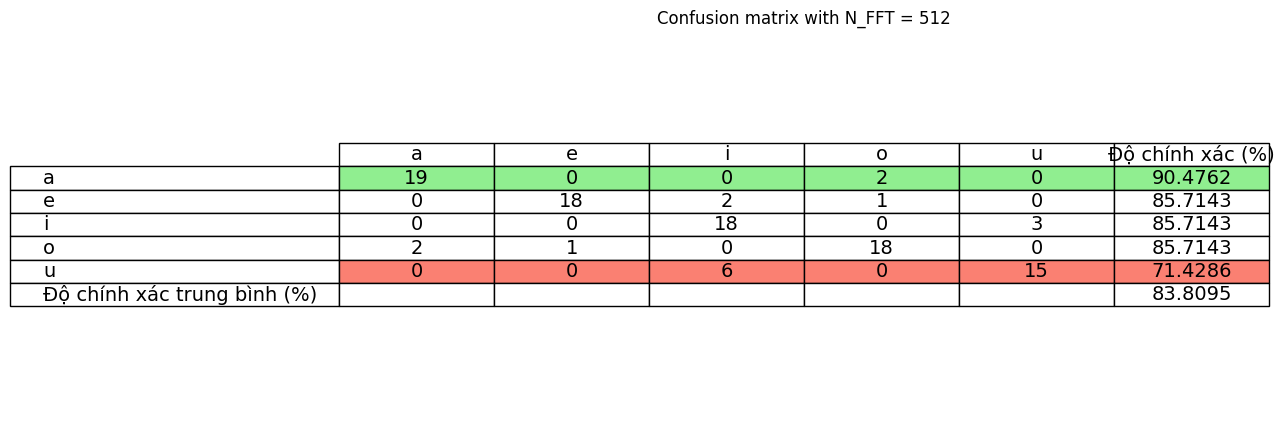

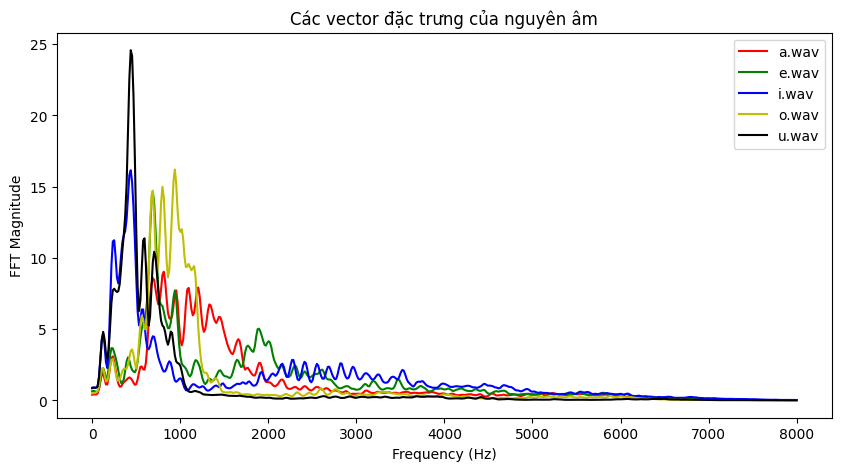

C:\Users\tienn\AppData\Local\Temp\ipykernel_17400\2383558284.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read(filepath)


[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 19, 0, 0, 2, 0, 0], ['e', 0, 18, 2, 1, 0, 0], ['i', 0, 0, 18, 0, 3, 0], ['o', 2, 1, 0, 18, 0, 0], ['u', 0, 0, 6, 0, 15, 0], ['Độ chính xác trung bình (%)', '', '', '', '', '', 0]]
[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 19, 0, 0, 2, 0, 90.47619047619048], ['e', 0, 18, 2, 1, 0, 85.71428571428571], ['i', 0, 0, 18, 0, 3, 85.71428571428571], ['o', 2, 1, 0, 18, 0, 85.71428571428571], ['u', 0, 0, 6, 0, 15, 71.42857142857143], ['Độ chính xác trung bình (%)', '', '', '', '', '', 83.80952380952382]]


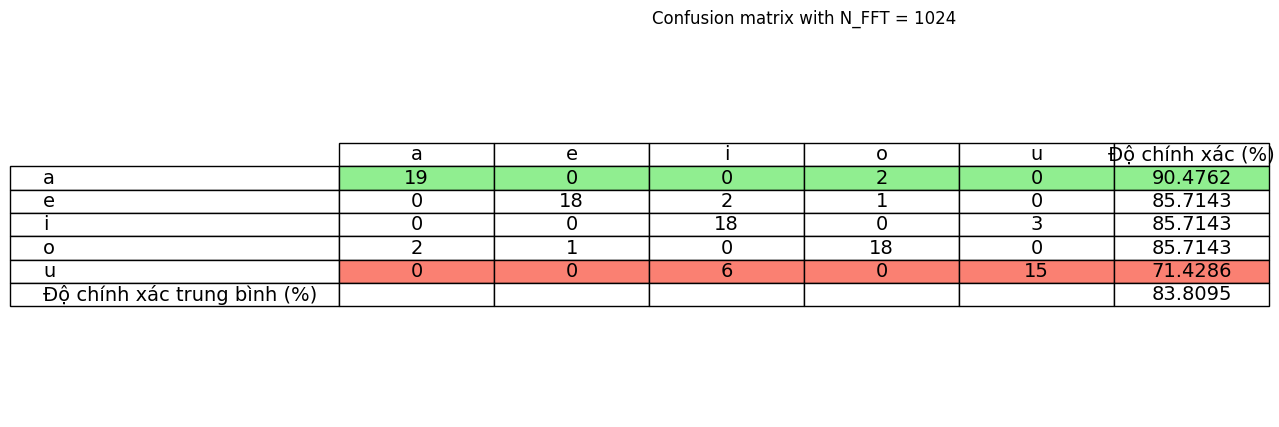

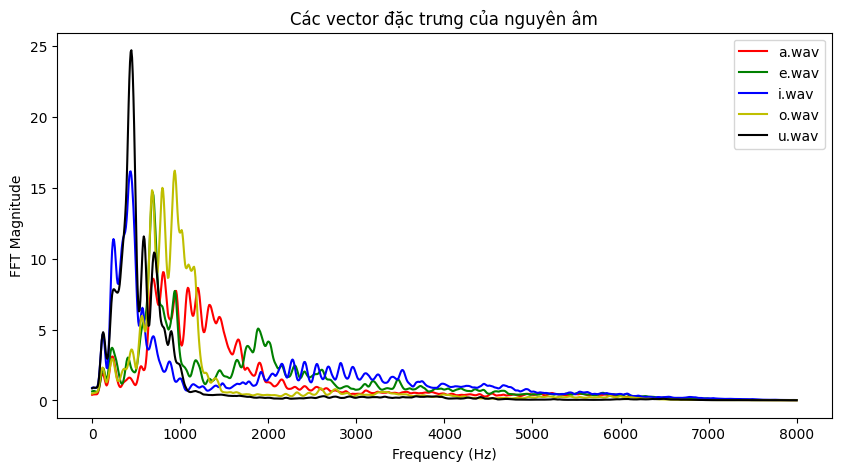

C:\Users\tienn\AppData\Local\Temp\ipykernel_17400\2383558284.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wavfile.read(filepath)


[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 19, 0, 0, 2, 0, 0], ['e', 0, 18, 2, 1, 0, 0], ['i', 0, 0, 18, 0, 3, 0], ['o', 2, 1, 0, 18, 0, 0], ['u', 0, 0, 6, 0, 15, 0], ['Độ chính xác trung bình (%)', '', '', '', '', '', 0]]
[['', 'a', 'e', 'i', 'o', 'u', 'Độ chính xác (%)'], ['a', 19, 0, 0, 2, 0, 90.47619047619048], ['e', 0, 18, 2, 1, 0, 85.71428571428571], ['i', 0, 0, 18, 0, 3, 85.71428571428571], ['o', 2, 1, 0, 18, 0, 85.71428571428571], ['u', 0, 0, 6, 0, 15, 71.42857142857143], ['Độ chính xác trung bình (%)', '', '', '', '', '', 83.80952380952382]]


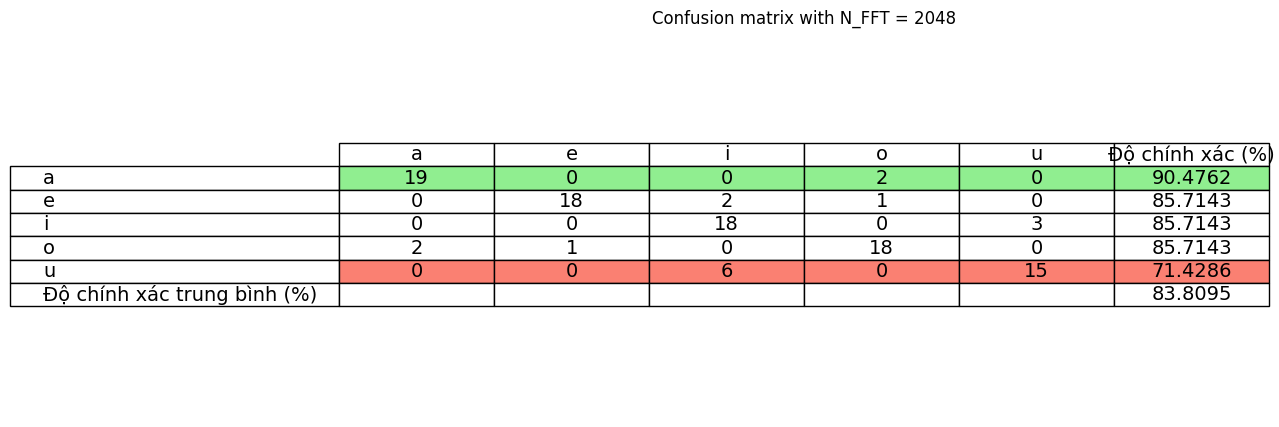

In [569]:
#initialize
path_hl, path_kt, folders_hl, folders_kt, files, f_d, f_s, N_FFTs, N_MFCCs, Ks = initialize()
#Bai2
Bai2(path_hl, path_kt, folders_hl, folders_kt, files, N_FFTs, f_d, f_s)